In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
%matplotlib widget
from src.strain import *

# for get2dpucks
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 14.28it/s]


In [6]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [7]:
test_pat_index = 0

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [15]:
# let's try to use 9 pucks, if we divide into N=3 sections, we define each section to be 3 pucks
def get2dPuckEndpoints(abin, apix, npucks=9):
    '''
    Originally:
        get2dPucks(abin, apix): Return the linear extent of the binary structure,
        as well as a sequence of radii about that extent.
    Now just used to return the endpoints of the pucks representing the endpoints of the individual
    radii parallel to the minor axis
    '''
    
    all_puck_endpoints = []
    
    
    # Empty bin?
    if ~np.any(abin):
        return 1.0, np.zeros((npucks,))
    
    x,y = np.where(abin>0)
    X = np.stack([x,y]) # Coords of all non-zero pixels., 2 x N
    if X.shape[1] < 1: # no pixels, doesn't seem to be a problem usually. 
        return (0.0, np.zeros((npucks,)))
    # Scale dimensions
    X = np.multiply(X, np.array(apix)[:, None]) # Need a broadcastable shape, here 2 x 1
    try:
        val, vec = np.linalg.eig(np.cov(X, rowvar=True))
    except:
        return (0.0, np.zeros((npucks,)))
    
    # Make sure we're in decreasing order of importance.
    eigorder = np.argsort(val)[-1::-1]
    vec = vec[:, eigorder]
    val = val[eigorder]
    
    # Negate the eigenvectors for consistency. Let's say y should be positive eig0,
    # and x should be positive for eig1. I'm not sure if that's what I'm doing here,
    # but just trying to be consistent.
    if vec[0,0] < 0:
        vec[:,0] = -1.0*vec[:,0]
    if vec[1,1] < 0:
        vec[:,1] = -1.0*vec[:,1]
    
    mu = np.expand_dims(np.mean(X, axis=1), axis=1)
    
    # Now mu is 2 x 1 mean pixel coord 
    # val is eigenvalues, vec is 2 x 2 right eigvectors (by column), all in matrix ij format
    
    # Use the boundary to get the radii.
    # Project the boundary pixel coords into the eigenspace.
    B = find_boundaries(abin, mode='thick')
    Xb = np.stack(np.where(B))
    Xb = np.multiply(Xb, np.array(apix)[:, None]) # space coords again.
    proj = np.dot((Xb-mu).T,vec) 
    # proj is M x 2, the projections onto 0 and 1 eigs of the M boundary coords.
    
    # Now get min max in the first principal direction. That's L! Just L[0] here.
    L_min, L_max = np.min(proj, axis=0), np.max(proj, axis=0)
    L = L_max - L_min
    
    # Partition along the principal axis. The secondary axis represents the radii.
    L_partition = np.linspace(L_min[0], L_max[0], npucks+1)
    
    R = []
    A = np.copy(proj)
    for i in range(len(L_partition)-1):
        # Select those boundary points whose projection on the major axis
        # is within the thresholds. 
        which = np.logical_and(A[:,0] >= L_partition[i],
                               A[:,0] < L_partition[i+1])
        # here which could be empty, if there are multiple components to the binary,
        # which will happen without cleaning for the largest connected component and 
        # such. r will be nan, here I replace with zero.
        # In fact, this math really only works well with nice convex objects.
        if len(which) == 0:
            r = 0
        else:
            r = np.median(np.abs(A[:,1][which]))
        R.append(r)
    
    # Some visualization code I didn't know where else to put!
    # B is still in image coords, while mu and the vec and L's are in mm? Use extent.
    # extent = (-0.5, apix[1]*B.shape[1]-0.5, -0.5, apix[0]*B.shape[0]-0.5)# (left, right, bottom, top)

    # This got me pretty confused. The issue is that if apix is something other than (1,1), then 
    # B needs to be scaled accordingly. 
    # If apix is significantly less than 1,1, then the 0 order and no anti-aliasing could
    # leave little of the boundary left. Though it would only affect the vis, as the calculation
    # above scaled the boundary points to double, instead of this which returns pixels.
    abin_scaled = rescale(abin, apix, order=0, 
                          preserve_range=True, 
                          anti_aliasing=False, 
                          multichannel=False)
    Bscaled = find_boundaries(abin_scaled, mode='thick')


    # Plot the mean and principal projections. But plot needs xy (euclid) instead of ij (matrix)!!!
    # Stupid, keeping the sliced out dimension with None here.
    pca0 = np.array([mu + L_min[0]*vec[:,0, None], mu + L_max[0]*vec[:,0, None]])
    pca1 = np.array([mu + L_min[1]*vec[:,1, None], mu + L_max[1]*vec[:,1, None]])

    # Notice the x and y coord reversed. 

    # these are only the end points of the major and minor axes I think ? 
    # plt.scatter(x=mu[1], y=mu[0], s=30, marker='*') # what is this one? ?? -- hard to tell, no visual difference?


    # this plots all of the points of the individual lines of the npucks 
    for i in range(len(L_partition)-1):

        extent = (L_partition[i]+L_partition[i+1])/2
        points = np.array([mu + extent*vec[:,0, None] - R[i]*vec[:,1, None], # negative radius
                           mu + extent*vec[:,0, None] + R[i]*vec[:,1, None]]) # positive radius

        all_puck_endpoints.append(np.transpose(points))
    
    # return L[0], np.array(R), np.array(all_puck_endpoints)
    return np.array(all_puck_endpoints)

In [16]:
I = ed_label

radiiEndpoints_I = get2dPuckEndpoints((I == 1).astype('int'), (1.0, 1.0))

I = give_boundary_no_basal_plane(ed_label)

In [17]:
radiiEndpoints_I.shape

(9, 1, 2, 2)

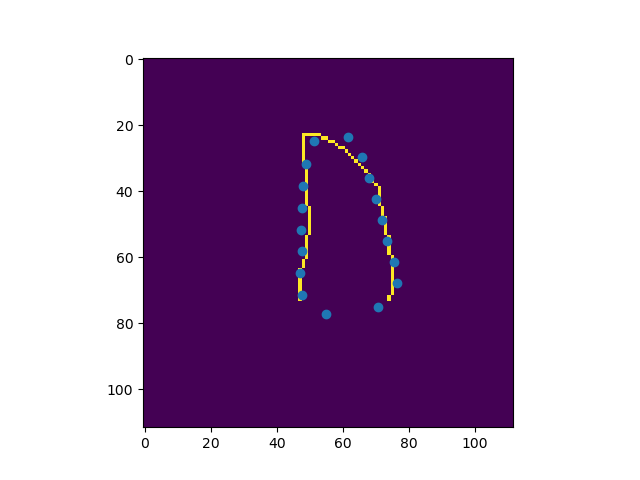

In [18]:
plt.figure()
plt.imshow(I)
plt.scatter(radiiEndpoints_I[:, 0, 1], radiiEndpoints_I[:, 0, 0])

In [19]:
N = 3
indeces_for_slice_points = []
for i in range(len(radiiEndpoints_I)-1, 0, -N):
    indeces_for_slice_points.append(i)
indeces_for_slice_points.sort()

indeces_for_slice_points

[2, 5, 8]

In [21]:
slice_points = []

for i in indeces_for_slice_points:
    slice_points.append(radiiEndpoints_I[i, 0, ...])
    
slice_points = np.array(slice_points)


slice_points

array([[[38.44081952, 35.98958544],
        [48.05716979, 68.001712  ]],

       [[58.24401858, 55.07382072],
        [47.52191566, 73.316329  ]],

       [[77.07631067, 75.12896298],
        [54.88647627, 70.73113125]]])

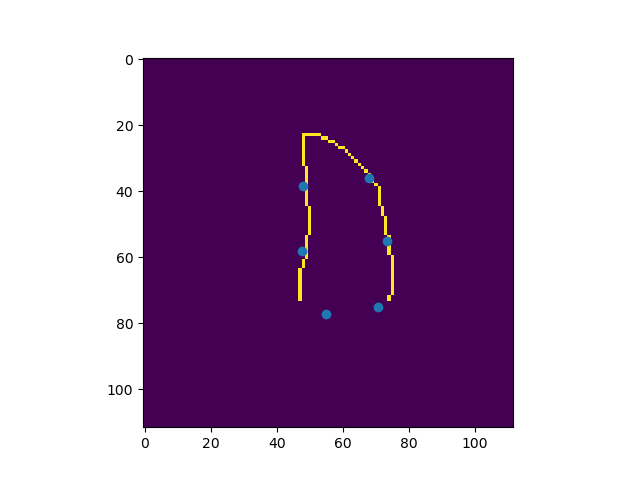

In [22]:
plt.figure()
plt.imshow(I)
plt.scatter(slice_points[:, 1], slice_points[:, 0]) # plot in x,y --- stored in i,j

In [23]:
# note that it is not (i,j) that is being stored! it is (i_0, i_1) lol....
# let's re-store it in another variable that's more intuitive

divide_points = [] # (i,j)
divide_points_i_vals = [] # i
divide_points_j_vals = [] # j

for a in slice_points:
    divide_points.append([ [a[0][0], a[1][0]] , [a[0][1], a[1][1]] ])
    divide_points_i_vals.append(a[0][0])
    divide_points_i_vals.append(a[0][1])
    divide_points_j_vals.append(a[1][0])
    divide_points_j_vals.append(a[1][1])

divide_points = np.array(divide_points)

divide_points

array([[[38.44081952, 48.05716979],
        [35.98958544, 68.001712  ]],

       [[58.24401858, 47.52191566],
        [55.07382072, 73.316329  ]],

       [[77.07631067, 54.88647627],
        [75.12896298, 70.73113125]]])

In [24]:
# need to transform the image pixels into a set of points (i,j)
I_point_set = []
I_point_set_i_vals = []
I_point_set_j_vals = []

for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if I[i][j] == 1:
            I_point_set.append([i,j])
            I_point_set_i_vals.append(i)
            I_point_set_j_vals.append(j)

I_point_set = np.array(I_point_set)

print(I_point_set.shape, np.count_nonzero(I == 1)) # number of points count should match

(109, 2) 109


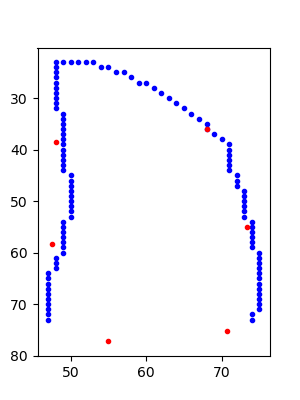

In [25]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.scatter(I_point_set_j_vals, I_point_set_i_vals, marker='.', color='b', zorder=1)
ax.scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=2)
ax.invert_yaxis()

Now we need to check whether the set of points representing the lv is above or below the imaginary line drawn by each pair of slice points. We can do this by checking the sign value of taking the determinant of this matrix: 
$$\begin{bmatrix} x_2 - x_1 & x_3 - x_1 \\ y_2 - y_1 & y_3 - y_1 \end{bmatrix} $$
where $(x_1, y_1)$ and $(x_2, y_2)$ are the pair of points representing the imaginary line between them and $(x_3, y_3)$ represents the point to be checked. 

- $> 0 $ then above line
- $< 0 $ then below line
- $= 0 $ then on line

This is taken from this [stackoverflow](https://stackoverflow.com/a/3461499/19266332).

In [26]:
def is_point_above_below_line(p1, p2, p3):
    '''
    input: p1, p2, p3 -- iterables containing (x,y)
        p1 and p2 represent line and p3 is point to be checked
        note that this is supposed to be in euclidean space (x,y) 
        if points are in (i,j) please convert them first into (x,y)
        x = j, y = i
    output:
        +1 for above line
        -1 for below line
        0 for on the line
    '''
    a = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    if a > 0:
        return 1
    elif a < 0:
        return -1
    else:
        return 0

In [27]:
def ij_to_xy(p):
    '''
    input: p - (i,j)
    output: p - (x,y)
    x = j, y = i
    '''
    return np.array([p[1], p[0]])

In [28]:
I_regional_point_sets = [0 for i in range(N)]

for i in range(N):
    curr_region_point_set = []
    tmp_point_count = 0
    
    # first region
    if i == 0:
        p1 = ij_to_xy(divide_points[i][0])
        p2 = ij_to_xy(divide_points[i][1])
        
        for point in I_point_set:
            p3 = ij_to_xy(point)
        
            if is_point_above_below_line(p1, p2, p3) == -1:
                curr_region_point_set.append(point)
                tmp_point_count += 1
                
        print(f'points in region i={i}: {tmp_point_count}')
        print(f'{p1} {p2}')
        
    # 2nd and + regions
    else:
        start_p1 = ij_to_xy(divide_points[i-1][0])
        start_p2 = ij_to_xy(divide_points[i-1][1])

        end_p1 = ij_to_xy(divide_points[i][0])
        end_p2 = ij_to_xy(divide_points[i][1])

        # look at the entire point set representing the entire lv
        for point in I_point_set:
            p3 = ij_to_xy(point)

            check_1 = is_point_above_below_line(start_p1, start_p2, p3)
            check_2 = is_point_above_below_line(end_p1, end_p2, p3)

            # print(check_1, check_2)

            # above the first line and below the second line
            # save point in (i,j) format
            if check_1 == 1 and check_2 == -1:
                curr_region_point_set.append(point)
                tmp_point_count += 1

        print(f'points in region i={i}: {tmp_point_count}')
        print(f'{start_p1} {start_p2} | {end_p1} {end_p2}')
    
    # save curr region point set
    I_regional_point_sets[i] = np.array(curr_region_point_set)
    
I_regional_point_sets = np.array(I_regional_point_sets)

points in region i=0: 36
[48.05716979 38.44081952] [68.001712   35.98958544]
points in region i=1: 39
[48.05716979 38.44081952] [68.001712   35.98958544] | [47.52191566 58.24401858] [73.316329   55.07382072]
points in region i=2: 34
[47.52191566 58.24401858] [73.316329   55.07382072] | [54.88647627 77.07631067] [70.73113125 75.12896298]


/opt/anaconda3/envs/dynamic37-wang/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


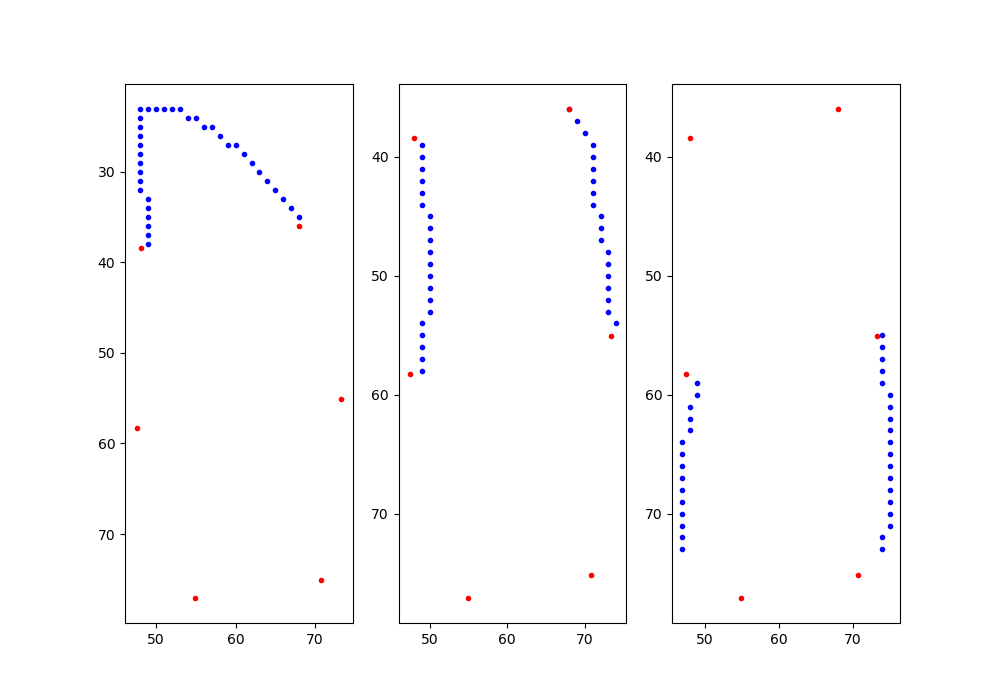

In [33]:
fig, ax = plt.subplots(1,3, figsize=(10,7))
ax[0].scatter(I_regional_point_sets[0][:, 1], I_regional_point_sets[0][:, 0], marker='.', color='b', zorder=2)
ax[0].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[0].invert_yaxis()

ax[1].scatter(I_regional_point_sets[1][:, 1], I_regional_point_sets[1][:, 0], marker='.', color='b', zorder=2)
ax[1].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[1].invert_yaxis()

ax[2].scatter(I_regional_point_sets[2][:, 1], I_regional_point_sets[2][:, 0], marker='.', color='b', zorder=2)
ax[2].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[2].invert_yaxis()